In [1]:
# General libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.metrics as met

# ETL library
from ETL import ETL

# Time series analysis
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, pacf, acf

# ARIMA and SARIMAX models
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima

# Statsmodels API
import statsmodels.api as sm

from datetime import datetime, timedelta


# Temporal Series

In [2]:
df = pd.read_csv('dataset/best_route_flights.csv')

In [3]:
df = ETL(df)

In [4]:
df['OP_CARRIER'].value_counts()

OP_CARRIER
UA    46929
WN    34735
VX    20157
AA    16997
OO    14545
DL     9608
AS     3309
CO        8
Name: count, dtype: int64

In [5]:
df = df[(df['CANCELLED'] != 1) & (df['DIVERTED'] != 1) & (df['OP_CARRIER'] == 'UA')]
df = df[['FL_DATE', 'DEP_DELAY', 'ARR_DELAY', 'ORIGIN', 'DEST', 'DISTANCE', 'AIR_TIME']]

df.head()


,FL_DATE,DEP_DELAY,ARR_DELAY,ORIGIN,DEST,DISTANCE,AIR_TIME
0,2009-01-01,-2.0,-20.0,SFO,LAX,337.0,56.0
1,2009-01-01,-8.0,-28.0,SFO,LAX,337.0,54.0
2,2009-01-01,5.0,-8.0,SFO,LAX,337.0,55.0
3,2009-01-01,13.0,-7.0,SFO,LAX,337.0,53.0
4,2009-01-01,-6.0,-29.0,SFO,LAX,337.0,53.0


In [6]:
# Convertire 'FL_DATE' in formato datetime e normalizzarlo
df['FL_DATE'] = pd.to_datetime(df['FL_DATE'])
df['FL_DATE'] = df['FL_DATE'].dt.normalize()

# Calcolare la data massima nel dataset e la data di inizio degli ultimi 4 mesi
max_date = df['FL_DATE'].max()
four_months_ago = max_date - pd.DateOffset(months=4)

# Filtrare il dataframe per gli ultimi 4 mesi del dataset
filtered_df = df[df['FL_DATE'] >= four_months_ago]

# Creare l'analisi giornaliera sui dati filtrati
daily_analysis = filtered_df.groupby("FL_DATE").agg(
    AVG_DEP_DELAY=("DEP_DELAY", "mean"),
    AVG_ARR_DELAY=("ARR_DELAY", "mean"),
    AVG_AIR_TIME=("AIR_TIME", "mean"), 
    NUM_FLIGHTS=("FL_DATE", "size")
).fillna(0)

# Applicare una media mobile esponenziale
daily_analysis['EMA_ARR_DELAY'] = daily_analysis['AVG_ARR_DELAY'].ewm(span=30, adjust=False).mean()

daily_analysis

,AVG_DEP_DELAY,AVG_ARR_DELAY,AVG_AIR_TIME,NUM_FLIGHTS,EMA_ARR_DELAY
FL_DATE,,,,,
2018-08-31,8.928571,3.500000,53.000000,14,3.500000
2018-09-01,6.000000,-10.142857,52.142857,7,2.619816
2018-09-02,3.000000,-7.000000,54.714286,7,1.999182
2018-09-03,1.785714,3.928571,56.142857,14,2.123659
2018-09-04,0.428571,1.857143,57.214286,14,2.106465
...,...,...,...,...,...
2018-12-27,6.500000,4.666667,52.000000,12,12.125613
2018-12-28,12.833333,10.166667,54.833333,12,11.999230
2018-12-29,5.000000,-0.333333,55.000000,9,11.203580


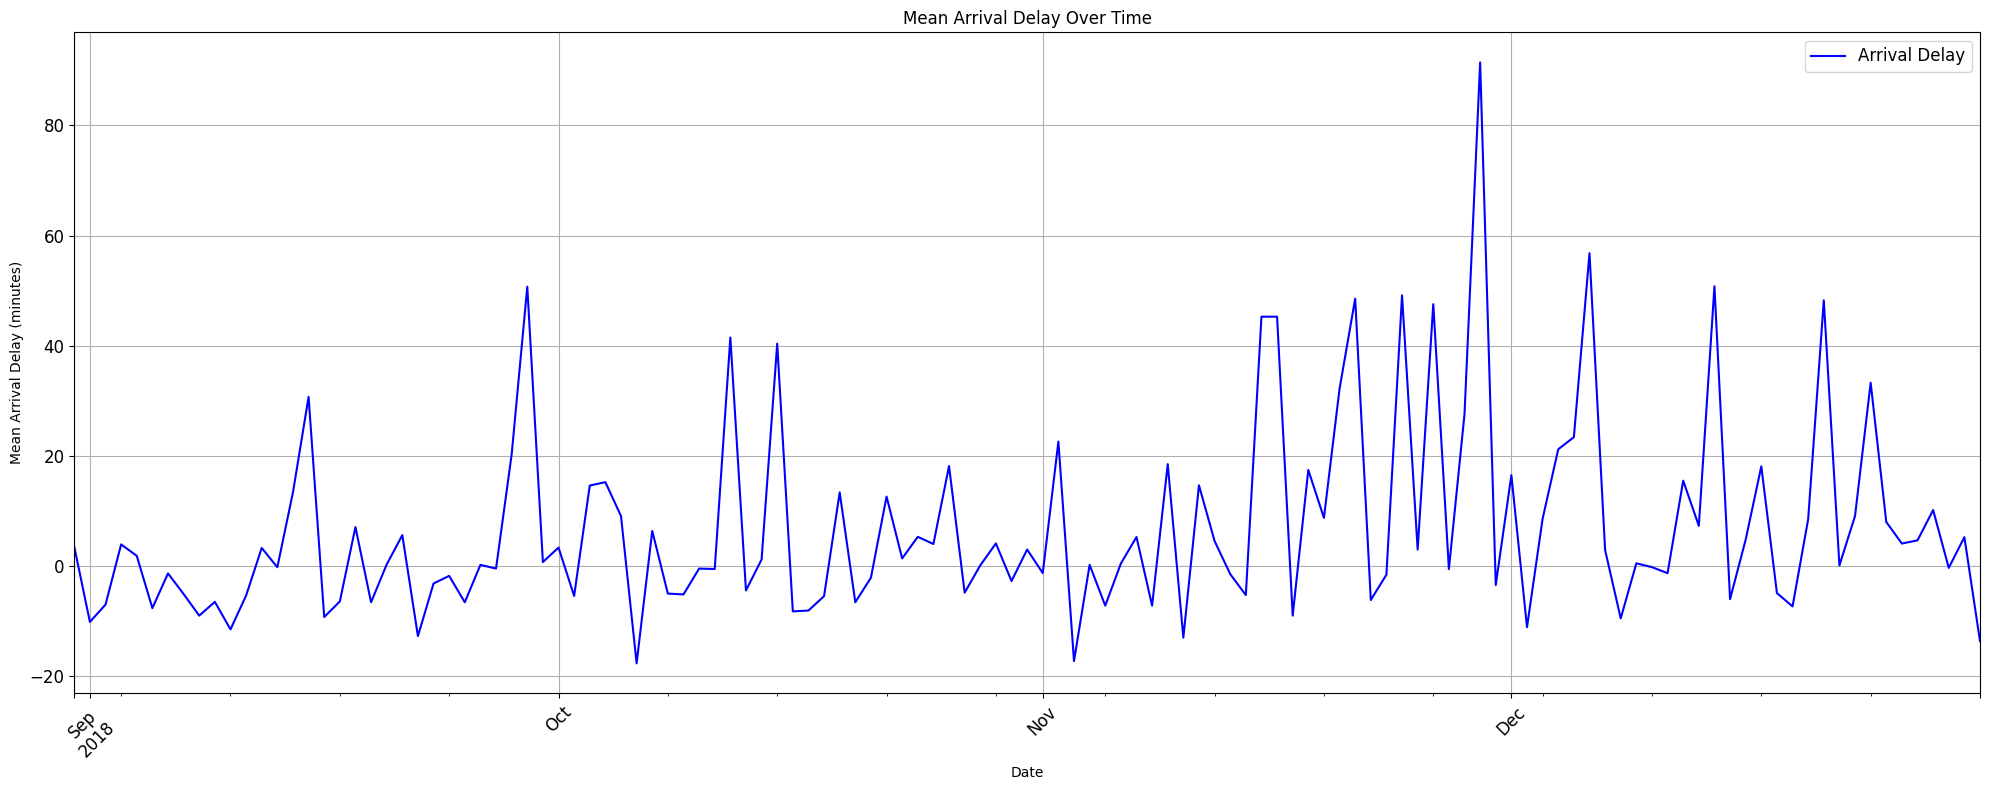

In [7]:
# Grafico del ritardo totale nel tempo (partenza e arrivo)
daily_analysis["AVG_ARR_DELAY"].plot(
    figsize=(20, 8), linestyle='-', color='b', 
    title="Mean Arrival Delay Over Time", grid=True, 
    xlabel="Date", ylabel="Mean Arrival Delay (minutes)", label="Arrival Delay"
)
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

In [8]:
# Creare un range di date che va dalla prima alla ultima data
date_range = pd.date_range(start=daily_analysis.index.min(), end=daily_analysis.index.max(), freq='D')

# Confrontare il range con l'indice delle date nel dataframe
missing_dates = date_range.difference(daily_analysis.index)

# Visualizzare le date mancanti
print(missing_dates)

DatetimeIndex([], dtype='datetime64[ns]', freq='D')


In [9]:
# Creare un nuovo dataframe con tutte le date
all_dates_df = pd.DataFrame(index=date_range)

# Unire il dataframe con daily_analysis per includere anche le date mancanti
daily_analysis_full = all_dates_df.join(daily_analysis, how='left')

# Interpolare i valori mancanti in base al tempo
daily_analysis_full_interpolated = daily_analysis_full.interpolate(method='time')

# Visualizzare il risultato
print(daily_analysis_full_interpolated)

            AVG_DEP_DELAY  AVG_ARR_DELAY  AVG_AIR_TIME  NUM_FLIGHTS  \
2018-08-31       8.928571       3.500000     53.000000           14   
2018-09-01       6.000000     -10.142857     52.142857            7   
2018-09-02       3.000000      -7.000000     54.714286            7   
2018-09-03       1.785714       3.928571     56.142857           14   
2018-09-04       0.428571       1.857143     57.214286           14   
...                   ...            ...           ...          ...   
2018-12-27       6.500000       4.666667     52.000000           12   
2018-12-28      12.833333      10.166667     54.833333           12   
2018-12-29       5.000000      -0.333333     55.000000            9   
2018-12-30       9.083333       5.250000     52.333333           12   
2018-12-31      -2.000000     -13.625000     51.375000            8   

            EMA_ARR_DELAY  
2018-08-31       3.500000  
2018-09-01       2.619816  
2018-09-02       1.999182  
2018-09-03       2.123659  
2018-09

## Arrival Delay

<Axes: >

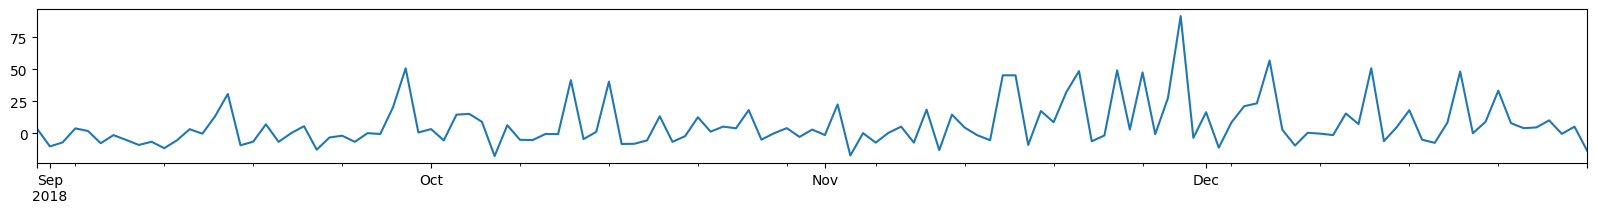

In [10]:
daily_analysis_arr = daily_analysis_full_interpolated['AVG_ARR_DELAY']
# Creare un intervallo completo di date che copra tutte le date nel dataset
full_index = pd.date_range(start=daily_analysis.index[0], end=daily_analysis.index[-1], freq='D')

# Allineare daily_analysis_arr con il nuovo indice completo
daily_analysis_arr = daily_analysis['AVG_ARR_DELAY'].reindex(full_index)

# Gestire i valori mancanti (NaN) con interpolazione, propagazione, o riempiendo con 0
daily_analysis_arr.interpolate(method='time', inplace=True)  # Interpolazione lineare basata sul tempo

daily_analysis_arr.plot(figsize=(20, 2))


### Stazionarietà

In [11]:
X = daily_analysis_arr.values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -10.372675
p-value: 0.000000
Critical Values:
	1%: -3.485
	5%: -2.886
	10%: -2.580


### Stagionalità, trend e residui

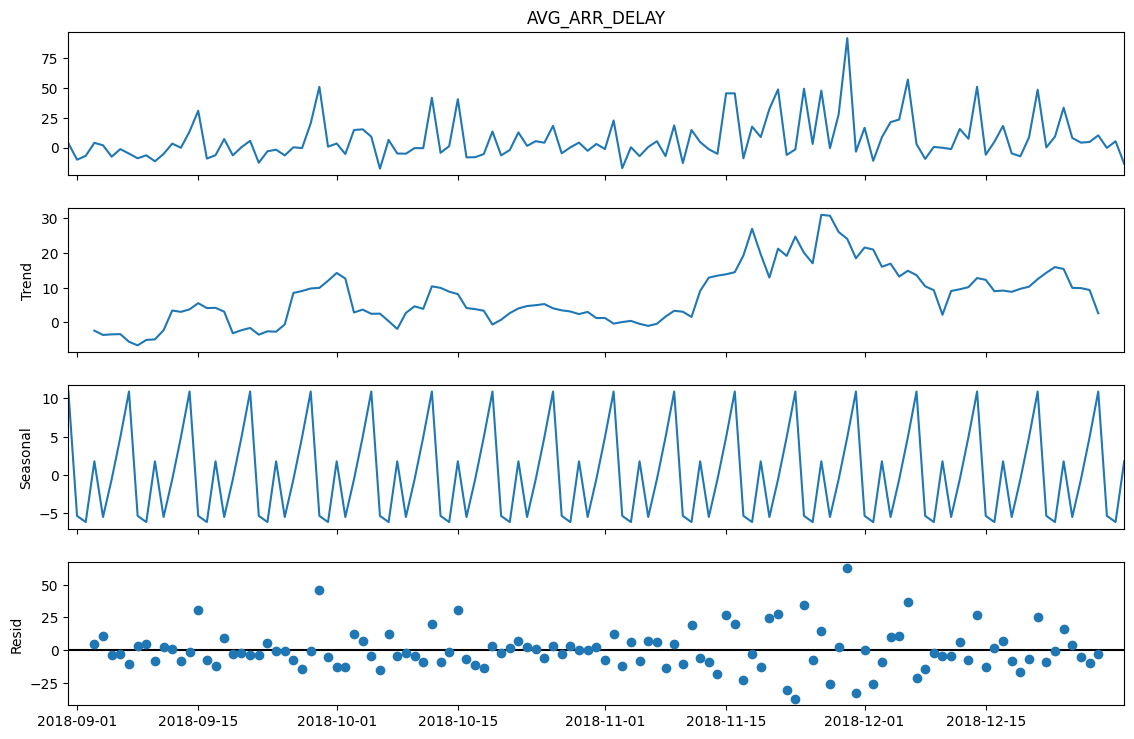

In [12]:
# Perform seasonal decomposition
dec2 = seasonal_decompose(daily_analysis_arr.asfreq('D').interpolate('linear'), model='additive')
fig = dec2.plot()
fig.set_size_inches(12, 8)  # Specifica larghezza e altezza in pollici
plt.show()


In [13]:
# Perform seasonal decomposition
dec2 = seasonal_decompose(daily_analysis_arr.asfreq('D').interpolate('linear'), model='additive')

# Stampa i valori della componente stagionale
dec2.seasonal[:10]

2018-08-31    10.891048
2018-09-01    -5.352515
2018-09-02    -6.158006
2018-09-03     1.772076
2018-09-04    -5.498142
2018-09-05    -0.581765
2018-09-06     4.927304
2018-09-07    10.891048
2018-09-08    -5.352515
2018-09-09    -6.158006
Freq: D, Name: seasonal, dtype: float64

### Autocorrelazione Parziale e Autocorrelazione

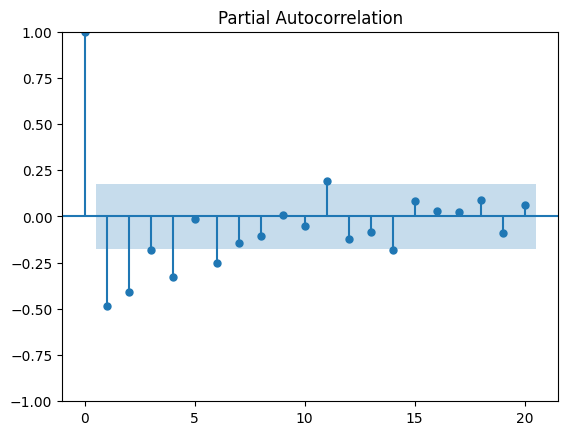

In [14]:
sm.graphics.tsa.plot_pacf(daily_analysis_arr.diff().dropna(), lags=20, method="ywm")
plt.show()

In [15]:
# Calcolo delle differenze
diff = daily_analysis_arr.diff().dropna()

# Calcolo dei valori di PACF per 20 lag
pacf_values = pacf(diff, nlags=20, method="ywm")

# Conta i valori superiori a 0.1 o inferiori a -0.1 (zona di confidenza)
count_above_01 = (pacf_values > 0.2).sum()
count_below_01 = (pacf_values < -0.2).sum()

print(f"Numero di valori PACF superiori a 0.1 nei primi 20 lag: {count_above_01}")
print(f"Numero di valori PACF inferiori a -0.1 nei primi 20 lag: {count_below_01}")

Numero di valori PACF superiori a 0.1 nei primi 20 lag: 1
Numero di valori PACF inferiori a -0.1 nei primi 20 lag: 4


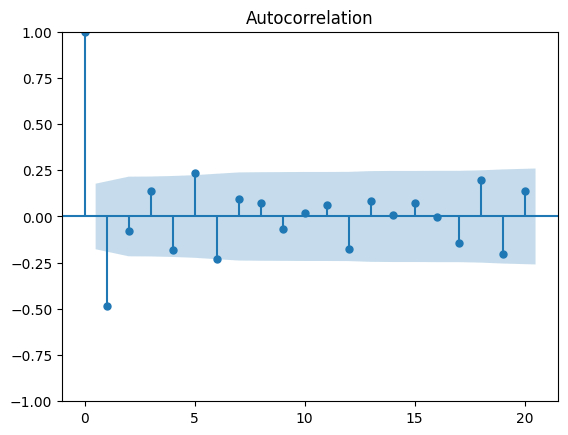

In [16]:
sm.graphics.tsa.plot_acf(daily_analysis_arr.diff().dropna(), lags=20)
plt.show()

In [17]:
# Calcolo delle differenze
diff = daily_analysis_arr.diff().dropna()

# Calcolo dei valori di autocorrelazione per 40 lag
acf_values = acf(diff, nlags=20)

# Conta i valori superiori a 0.1 o inferiori a -0.1 (zona di confidenza)
count_above_01 = (acf_values > 0.2).sum()
count_below_01 = (acf_values < -0.2).sum()

print(f"Numero di autocorrelazioni superiori a 0.1 nei primi 20 lag: {count_above_01}")
print(f"Numero di autocorrelazioni inferiori a -0.1 nei primi 20 lag: {count_below_01}")


Numero di autocorrelazioni superiori a 0.1 nei primi 20 lag: 2
Numero di autocorrelazioni inferiori a -0.1 nei primi 20 lag: 3


### Prediction

In [18]:
# Numero di osservazioni nel dataset
nobs = len(daily_analysis_arr)

# Determinare l'intervallo di date
start_date = daily_analysis_arr.index.min()  # Data minima
end_date = daily_analysis_arr.index.max()    # Data massima

# Calcolare le date di separazione
training_end_date = start_date + pd.DateOffset(months=3)  # Fine dei primi 3 mesi
test_start_date = training_end_date                      # Inizio dell'ultimo mese

# Separare i dati in training e test set
training_data = daily_analysis_arr[:training_end_date]
test_data = daily_analysis_arr[test_start_date:]

n_init_training = nobs - len(test_data)

In [19]:
# Applichiamo auto_arima per selezionare automaticamente i parametri
model = auto_arima(training_data, seasonal=True, m=7, stepwise=True, trace=True)

# Sommario del modello trovato
model.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=778.727, Time=1.10 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=849.249, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=823.423, Time=0.37 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=787.624, Time=0.23 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=847.250, Time=0.02 sec
 ARIMA(2,1,2)(0,0,1)[7] intercept   : AIC=783.026, Time=0.32 sec
 ARIMA(2,1,2)(1,0,0)[7] intercept   : AIC=781.929, Time=0.25 sec
 ARIMA(2,1,2)(2,0,1)[7] intercept   : AIC=776.049, Time=0.56 sec
 ARIMA(2,1,2)(2,0,0)[7] intercept   : AIC=774.131, Time=0.51 sec
 ARIMA(1,1,2)(2,0,0)[7] intercept   : AIC=781.616, Time=1.57 sec
 ARIMA(2,1,1)(2,0,0)[7] intercept   : AIC=777.907, Time=0.34 sec
 ARIMA(3,1,2)(2,0,0)[7] intercept   : AIC=775.787, Time=0.51 sec
 ARIMA(2,1,3)(2,0,0)[7] intercept   : AIC=774.820, Time=1.17 sec
 ARIMA(1,1,1)(2,0,0)[7] intercept   : AIC=780.289, Time=0.36 sec
 ARIMA(1,1,3)(2,0,0)[7] intercept   : AIC=772.8

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   92
Model:             SARIMAX(1, 1, 3)x(2, 0, [], 7)   Log Likelihood                -379.369
Date:                            Thu, 20 Feb 2025   AIC                            772.737
Time:                                    18:10:31   BIC                            790.313
Sample:                                08-31-2018   HQIC                           779.828
                                     - 11-30-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6989      0.120     -5.810      0.000      -0.935      -0.463
ma.L1         -0.3600      0.163     -2.206      0.027      -0.680      -0.040
ma.L2         -0.7782      0.088     -8.830      0.000      -0.951      -0.605
ma.L3          0.4303      0.110      3.927      0.000       0.216       0.645
ar.S.L7       -0.1702      0.112     -1.526      0.127      -0.389       0.048
ar.S.L14       0.3924      0.110      3.570      0.000       0.177       0.608
sigma2       232.4449     32.743      7.099      0.000     168.270     296.620
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):                 8.96
Prob(Q):                              0.81   Prob(JB):                         0.01
Heteroskedasticity (H):               2.78   Skew:                             0.73
Prob(H) (two-sided):                  0.01   Kurtosis:                         3.46
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [20]:

# Forecast the fitted values
forecast = model.fittedvalues()

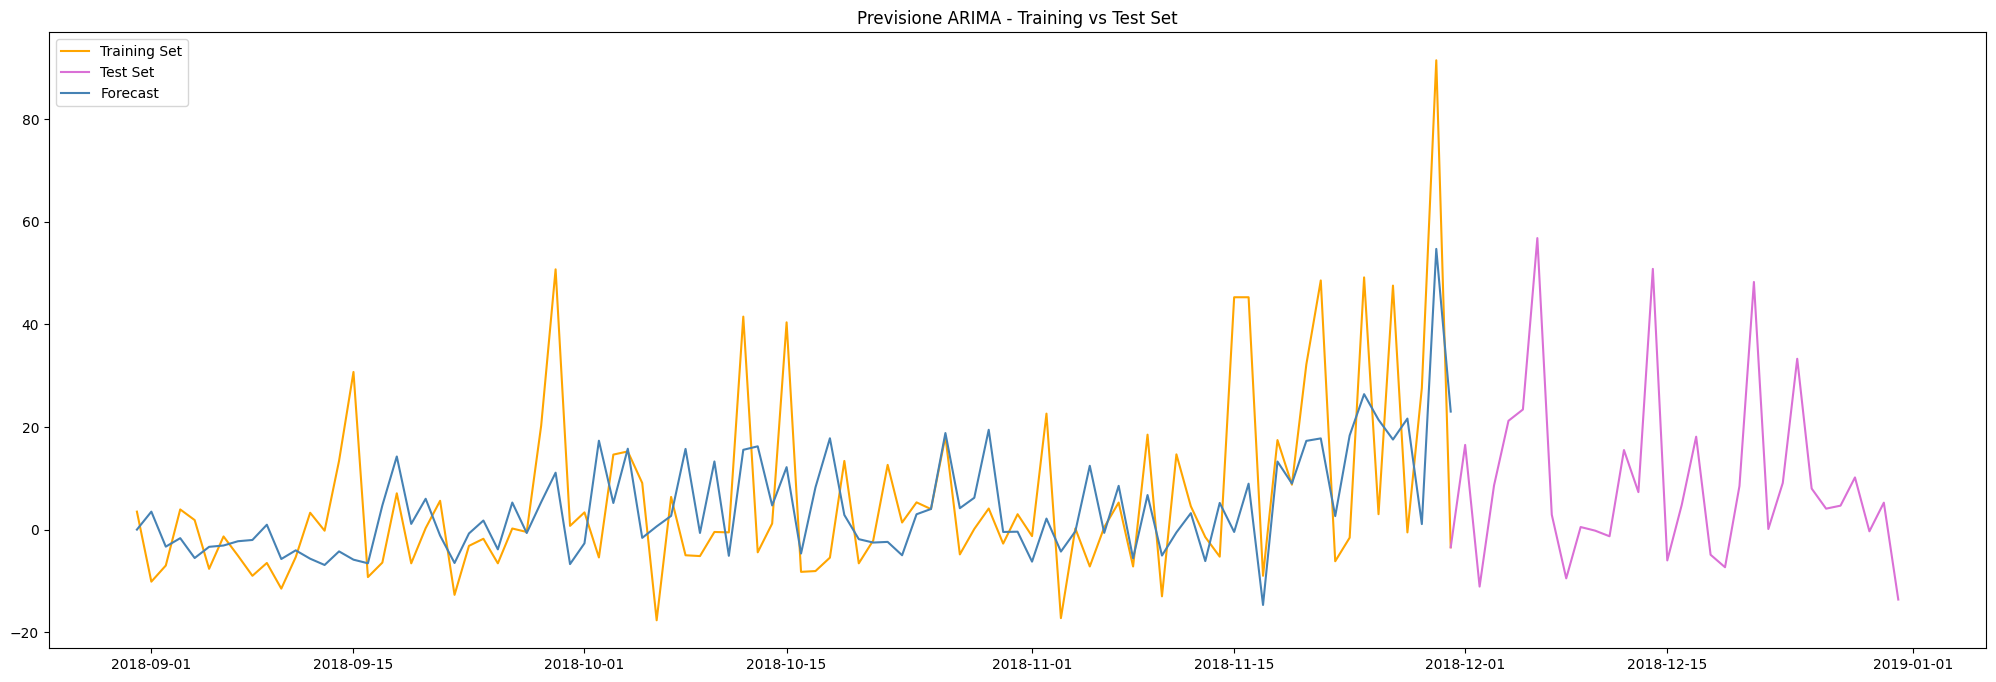

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                   92
Model:             SARIMAX(1, 1, 3)x(2, 0, [], 7)   Log Likelihood                -379.369
Date:                            Thu, 20 Feb 2025   AIC                            772.737
Time:                                    18:10:32   BIC                            790.313
Sample:                                08-31-2018   HQIC                           779.828
                                     - 11-30-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6989      0.120     -5.810      0.000      -0.935      -0.463
ma.L1         -0.3600      0.163   

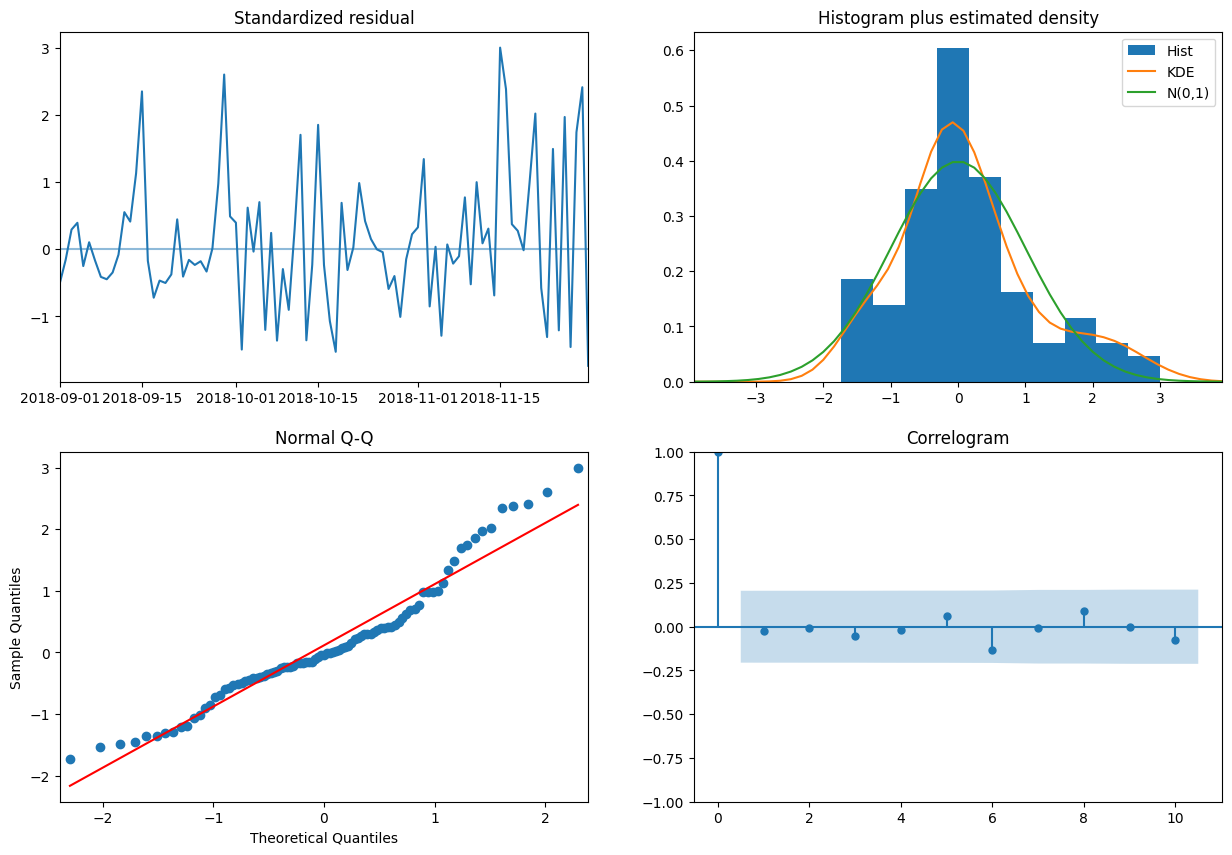

In [21]:
# Visualizzazione dei risultati
fig, ax = plt.subplots(figsize=(25, 8))

# Grafico dei dati
ax.plot(training_data, color='orange', label='Training Set')  
ax.plot(test_data, color='orchid', label='Test Set')  
ax.plot(forecast, color='steelblue', label='Forecast')  

# Aggiunta della legenda e del titolo
ax.legend(loc='upper left')
ax.set_title('Previsione ARIMA - Training vs Test Set')

# Mostra il grafico
plt.show()

# Stampa del sommario dei risultati del modello
print(model.summary())

# Dettagli aggiuntivi sul periodo considerato
print(f"Numero di elementi nel periodo: {nobs}")
print(f"Indice dell'ultimo elemento del training set: {n_init_training}")

# Diagnostica dei residui
model.plot_diagnostics(figsize=(15, 10))
plt.show()


### Predizione

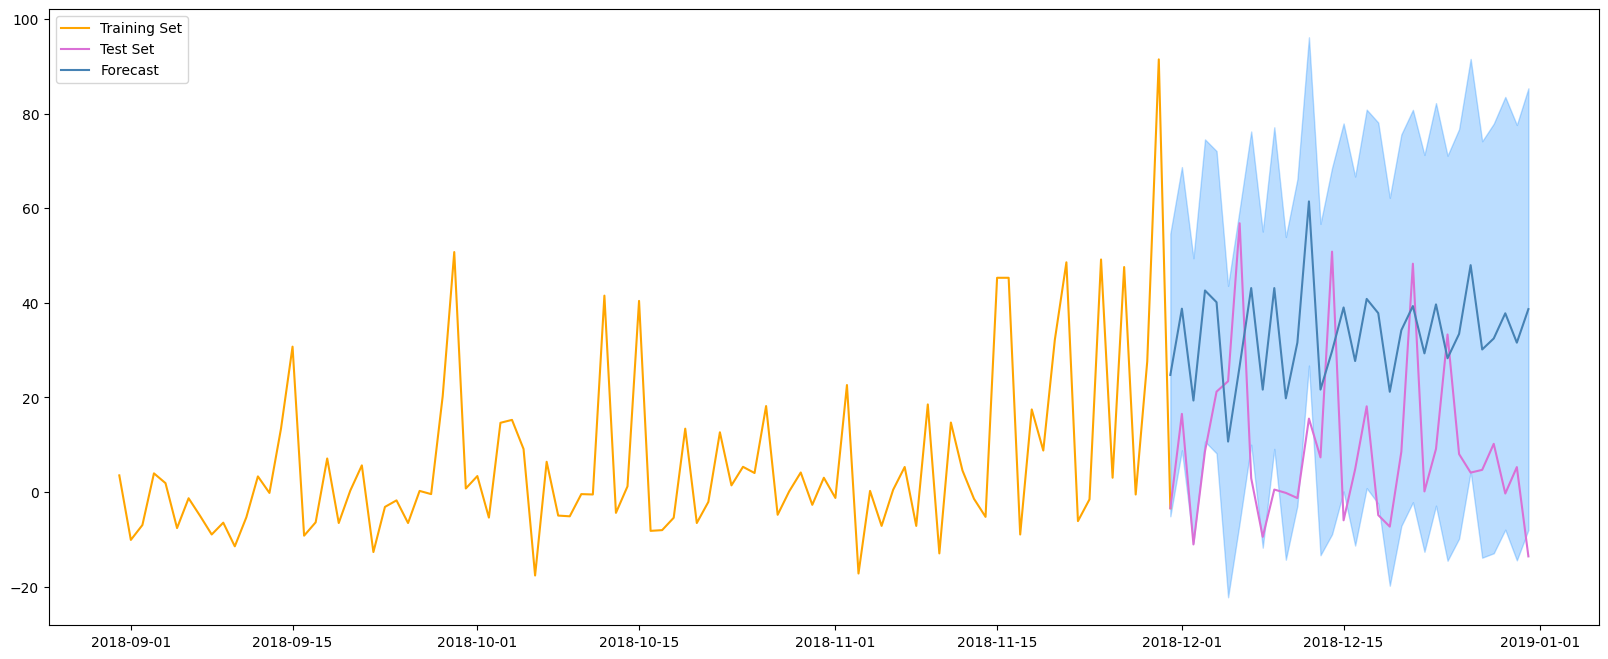

In [22]:
# Previsioni sui dati futuri
forecast, conf_int = model.predict(n_periods=len(test_data), return_conf_int=True)

# Grafico aggiornato
plt.figure(figsize=(20, 8))
plt.plot(training_data, color='orange')
plt.plot(test_data, color='orchid')
plt.plot(test_data.index, forecast, color='steelblue')
plt.fill_between(test_data.index, conf_int[:, 0], conf_int[:, 1], color='dodgerblue', alpha=0.3)
plt.legend(['Training Set', 'Test Set', 'Forecast'])
plt.show()


In [24]:
y_actual = daily_analysis_arr[test_data.index[0]:]
y_predicted = forecast

# Calculate MAPE
mape = met.mean_absolute_percentage_error(y_actual, y_predicted)
print('MAPE:', mape)

# Calculate MAE
mae = met.mean_absolute_error(y_actual, y_predicted)
print('MAE:', mae)

# Calculate SQE (Mean Squared Error)
mse = met.mean_squared_error(y_actual, y_predicted)
print('MSE:', mse)

# Calculate R2 score
r2 = met.r2_score(y_actual, y_predicted)
print('R2:', r2)


MAPE: 21.602411425096683
MAE: 28.73903186607348
MSE: 946.202060057805
R2: -2.241793147348924


### Out-sample prediciton

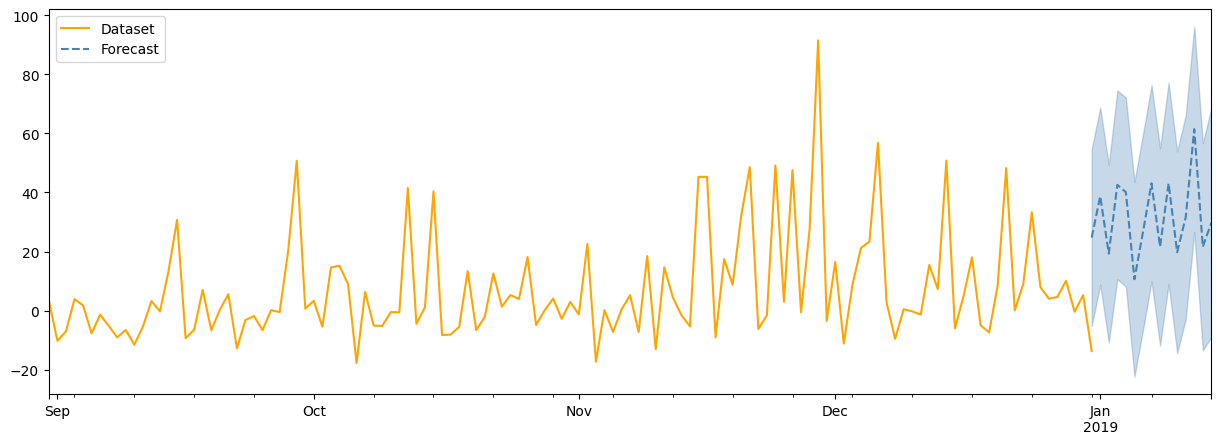

                 mean  mean_ci_lower  mean_ci_upper
2018-12-31  24.733889      -5.148006      54.615783
2019-01-01  38.740145       8.806333      68.673956
2019-01-02  19.323044     -10.750940      49.397027
2019-01-03  42.589926      10.651750      74.528103
2019-01-04  40.104848       8.143757      72.065939
2019-01-05  10.646729     -22.271218      43.564675
2019-01-06  26.590805      -6.484052      59.665662
2019-01-07  43.097910       9.993879      76.201940
2019-01-08  21.627148     -11.781162      55.035457
2019-01-09  43.096499       9.102354      77.090643
2019-01-10  19.787390     -14.325831      53.900610
2019-01-11  31.588899      -2.925843      66.103641
2019-01-12  61.418950      26.719983      96.117917
2019-01-13  21.637878     -13.383883      56.659639
2019-01-14  29.769873      -8.950249      68.489995


: 

In [ ]:
# Plot the data (here we are subsetting it to get a better look at the forecasts)
fig, ax = plt.subplots(figsize=(15, 5))

# Plot the dataset starting from 2017-12-01
daily_analysis_arr['2017-12-01':].plot(ax=ax, color='orange')

# Construct the forecasts using predict()
forecast, conf_int = model.predict(n_periods=15, return_conf_int=True)

# Construct forecast index for plotting
forecast_idx = pd.date_range(start=test_data.index[-1], periods=15, freq='D')

# Create a DataFrame for the forecast and confidence intervals
fcast = pd.DataFrame({
    'mean': (conf_int[:, 0]+conf_int[:, 1])/2,
    'mean_ci_lower': conf_int[:, 0],
    'mean_ci_upper': conf_int[:, 1]
}, index=forecast_idx)

# Plot the forecast
fcast['mean'].plot(ax=ax, style='--', color='steelblue')
ax.fill_between(fcast.index, fcast['mean_ci_lower'], fcast['mean_ci_upper'], color='steelblue', alpha=0.3)

# Add legend and show the plot
ax.legend(['Dataset', 'Forecast'])
plt.show()
print(fcast)
